In [0]:
import pandas as pd
import numpy as np
import itertools
from keras.preprocessing import text, sequence
from keras import utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [0]:
df=pd.read_json("Complete.json")

In [0]:
df.head(5)

,sentiment,text
0,Positive,"Thank you, Ellen. We have a strong 2018, with ..."
1,Positive,Stock-based compensation totaled $2.3 billion....
10,Negative,"For the full-year 2018, Other Bets revenues we..."
100,Neutral,Great. Thank you. I just wanted to follow up o...
1000,Neutral,Operator


In [0]:
df['sentiment'].value_counts()

Neutral     750
Positive    561
Negative    143
Name: sentiment, dtype: int64

In [0]:
train_size = int(len(df) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(df) - train_size))

Train size: 1163
Test size: 291


In [0]:
train_posts = df['text'][:train_size]
train_tags = df['sentiment'][:train_size]

test_posts = df['text'][train_size:]
test_tags = df['sentiment'][train_size:]

In [0]:
max_words = 300
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [0]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [0]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [0]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [0]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1163, 300)
x_test shape: (291, 300)
y_train shape: (1163, 3)
y_test shape: (291, 3)


In [0]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 32
epochs = 2

In [0]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 1046 samples, validate on 117 samples
Epoch 1/2
1046/1046 [==============================] - 0s 438us/step - loss: 0.9537 - acc: 0.5793 - val_loss: 0.8214 - val_acc: 0.6325
Epoch 2/2
1046/1046 [==============================] - 0s 154us/step - loss: 0.7301 - acc: 0.7390 - val_loss: 0.7658 - val_acc: 0.6496


In [0]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

291/291 [==============================] - 0s 74us/step
Test score: 0.8275496666783729
Test accuracy: 0.7079037802735555


In [0]:
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_posts.iloc[i][:50], "...")
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

Thanks, Matt. Rob, next question please. ...
Actual label:Neutral
Predicted label: Neutral

The next question comes from the line of Kate McSh ...
Actual label:Positive
Predicted label: Neutral

Hi. Thank you for taking my question. Just to dril ...
Actual label:Neutral
Predicted label: Neutral

I think two questions. On your first question arou ...
Actual label:Positive
Predicted label: Positive

Can you walk us through what the overall apparel s ...
Actual label:Positive
Predicted label: Neutral

Sure. I'm excited about -- later this week, I'm he ...
Actual label:Positive
Predicted label: Positive

And we have some new fixturing in some stores that ...
Actual label:Neutral
Predicted label: Positive

We've got a big apparel business. It has been grow ...
Actual label:Neutral
Predicted label: Positive

Online Grocery customers are a great example as th ...
Actual label:Positive
Predicted label: Positive

Thanks, Kate. Next question please. ...
Actual label:Neutral
Predicted label: Neut

In [0]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [0]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

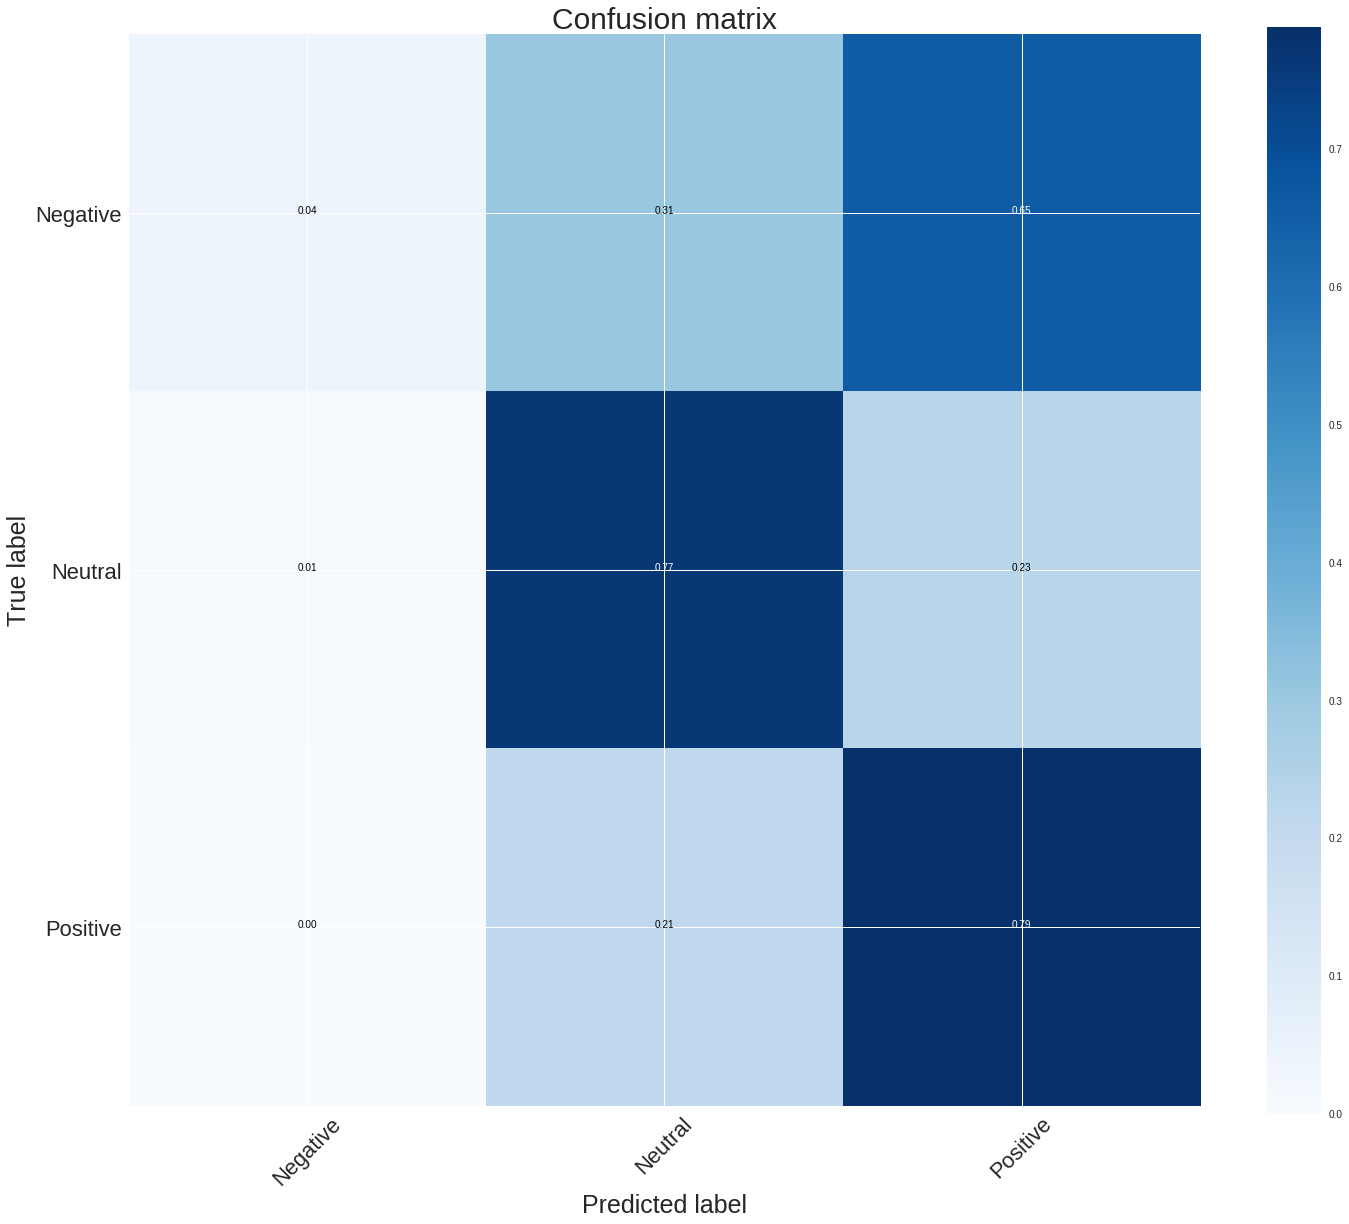

In [0]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()